# **Digit Recognition**

DSC-440 Project 2

Brian Chaffee

---
**Description:**

Using the MNIST dataset adapted from the Kaggle Competition. The objective is to create a Convolutional Neural Network that successfuly is able to predict the correct digit from 0 to 9 from a dataset of handwritten digits. 

I will be utilizing *data augmentation* with a Convolutional Neural Network built using the Keras API from Tensorflow in order to predict the the correct label of handwritten digits. Handwriting is often messy and subject to a wide array of noise whether that be the writing instrument or the paper or the ingrained 'neatness' from the individual. This project focuses on being able to accurately predict the handwritten digit and has applications beyond the dataset. Using machine learning to determine numbers from handwriting can help streamline many data entry methods. 

[Kaggle Link](https://www.kaggle.com/competitions/digit-recognizer/code?competitionId=3004&sortBy=voteCount&excludeNonAccessedDatasources=true) 

*The only adaptation is using `tensorflow.keras.datasets` instead of the provided datasets due to ease of import.*

## Imports
---

Utilizing the Keras package from Tensorflow due to the ease and intuitive aspects of creating the Neural Network 

In [1]:
# Imports
# # Basic Imports
import pandas as pd
import numpy as np

# # Machine Learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, regularizers


# # # Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # # Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


# # Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

## Loading Dataset
---

Utilizing the tensorflow library to load in the dataset from it's built in `load_data` function

In [2]:
from tensorflow.keras.datasets import mnist

# Loading dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Look at a small sample of the images in the dataset to vizualize what the handwritten digit images look like 

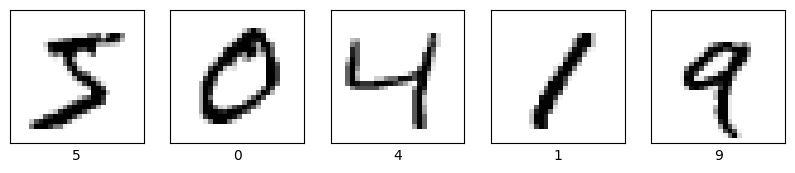

In [3]:
# Display example images
num_images = 5
plt.figure(figsize=(10, 3))
for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

Create a figure displaying the count of each digit to verify that they are equally distributed

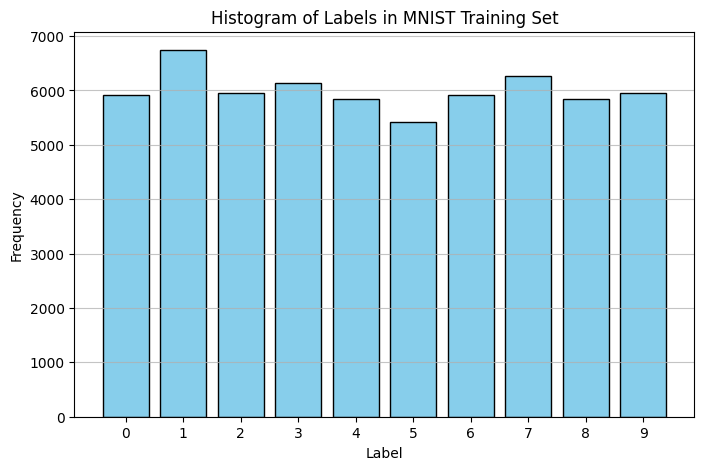

In [4]:
plt.figure(figsize=(8, 5))
plt.hist(y_train, bins=range(11), align='left', rwidth=0.8, color='skyblue', edgecolor='black')
plt.title('Histogram of Labels in MNIST Training Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.grid(axis='y', alpha=0.75)
plt.show()

## Data Preprocessing
---

The data needs to be normalized and reshaped in order to fit within the CNN structure that Keras accepts

The shape of the training and testing sets help determine preprocessing methods in order to fit within the model. Here, the shape shows that there are 60000 training imagees and there are a 28 pixels that represent the height and width.

In [5]:
print("Train images shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test images shape:", X_test.shape)
print("Test labels shape:", y_test.shape)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


### Normalizing

Normalizing the data basically grayscales the image and reduces the extra illumination around the edges. The data is divided by 255 because it reduces the color channels of the pixels and also reduces the effects that larger numbers may have on the model.

In [6]:
X_train = X_train / 255.0
X_test = X_test / 255.0

### Reshaping

The data also needs to be reshaped in order to be fit within a CNN model. The CNN requires an additional channel that represents the color of the image. Here it is represented as a one in order to describe the grayscale images.

In [7]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

## CNN
---

### Training and Validation Split
Creating the Convolutional Neural Network, the data needs to be split into training and testing (validation) sets. Here, 20 percent of the dataset is sectioned out in order to be used as a validation set for the model. 

*However, the dataset is already split into 60000 training points and 10000 testing points from the `load_data` package in keras.*

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.2)

### Data Augmentation

Data Augmentation is going to help reduce the possibility of overfitting the model by artifically increasing the amount of training data. Using the `ImageDataGenerator` from keras, a selection of changes are able to be input where the `X_train` data will be altered slightly when input into the model fitting.

The data is transformed slightly in order to simulate the variability in handwriting and increase the training set in order to reduce overfitting data. It is able to see multiple variations on the digits.

In [9]:
datagen = ImageDataGenerator(

    rotation_range = 15,        # rotate image randomly within range of 10 degrees
    width_shift_range = 0.1,    # shift image horizontally
    height_shift_range = 0.1,   # shift image vertically
    zoom_range = 0.1            # zooms image
)

datagen.fit(X_train)

The data could be flipped vertically and horizontally, however, some numbers like 6 and 9 look like each other when flipped

### Defining The Model

The Sequential function allows adding one layer at a time starting at input and working in order till the output layer. (Using Sequential, it recommends having an intial input layer rather in specifying input shape within the first layer). The input layer takes the width, heigth, and color channel of the image. In this instance, it is 28 x 28 x 1 (1 representing a grayscale).

The model has an initial convolutional layer that takes 112 filters and uses a 7x7 kernel size in order to determine the features from the images based within that 7x7 gridspace. This layer works to determine the broad characteristics and features from the images. Following the intial layer, there is a max pooling layer that works to reduce the dimensionality while maintaining the same number of features. The layers are then passed through a dropout layer in order to remove 25% of the neurons randomly and help reduce overfitting. The L2 regularizer works to limit the weights and prevent neurons from gaining too much influence and therefore smoothing out the layer inputs and outputs.

Following this main step of layers, there are two convolutional layers both consisting of 49 filters and kernel sizes of 3x3 and including an L2 regularizer at 0.001 like that of above. Following the convolutional layers, there is a Max Pooling layer in order to better reduce the dimensionality from the layers. There is then a final dropout layer attached that randomly drops 10% of the neurons from the previous section of convolutional layers. These layers work to find the deeper features withint the images.

The Flatten layer the proceeds functions as a way to transform the higher dimensional data from the Convolutional layers to one that the Neural Network is capable of processing and in the Dense layers and eventually towards an output.

The final dense layers work to make the final predictions from the feature extraction that was the Convolutional Layers.

In [ ]:
model = models.Sequential([

    # Input layer using 28 x 28 pixels and 1 color channel
    layers.Input(shape=(28,28,1)),

    layers.Conv2D(112, kernel_size = (7, 7), activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout((0.25)),

    layers.Conv2D(49, kernel_size = (3, 3), activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    layers.Conv2D(49, kernel_size = (3, 3), activation='relu', kernel_regularizer=regularizers.L2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout((0.1)),

    layers.Flatten(),

    layers.Dense(56, activation='relu', kernel_regularizer=regularizers.L2(0.0005)),
    layers.Dense(10, activation='softmax')
])

#### Definitions

**`Conv2D()` layer:**

A layer that works to capture the spatial patterns present in the images. Using a large kernel size helps find a broader spatial pattern. for the images and the L2 regularization present helps prevent overfitting of the model. The layers that use a smaller kernel size (3,3) work to find the more complex patterns within the data

**`MaxPooling2D()` layer:**

The max pooling layer downsamples the the dimensions by taking the maximum value of each region defined by the 2x2 square of pixels. This helps reduce overfitting and make computations more efficient.

**`Dropout()` layer:**

This layer randomly removes neurons at the rate defined within in order to reduce overfitting

**`Flatten()` layer:**

This layer works to flatten the input from the convolutional and pooling layers. The neural network (dense) layers can only operate on 1-Diminsional layers and therefore the Flatten layer is necessary in order to better make predictions on the training data.

**`Dense()` layer:**

The Dense layers work to make the final predictions based on the feature extractions. This is concluded with the final dense layer providing a filter for each of the possible digits.

**L2 Regularizer**

The L2 Regularizer uses a ridge regression and adds a weight in the form of a penalty to the loss function and keeping the model from attributing high weights to neurons and therefore allowing the model to be better at generalizing while being more stable across neurons. This helps keep the model from being overfit.

**Relu Activation Function**

The default activation function that alleviates the vanishing gradient problem and generally considered the best option for CNNs.

In [43]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

The compiler for the model uses what is generally considered the best options for convolutional neural networks

## Evaluating the Model
---

The model then runs through a number of iterations. Here, 12 epochs are chosen because when performing the same test with 12, the loss still decreases by each iteration indicating that the model is not overfitting. This can be seen in the verbose history from the model fitting as well as in the plotting graphs.

In [44]:
# Store altered variabels
epochs = 12
batch_size = 32

The model is then fit to the augmented data and validated with the X and y test sets. The model runs for 8 iterations and each iteration and accuracy alongside loss is recorded in the output below

In [ ]:
# Train the model
model_history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data = (X_test,y_test))

Epoch 1/12


/Users/brianchaffee/.pyenv/versions/3.10.4/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 49s 25ms/step - accuracy: 0.7999 - loss: 0.7642 - val_accuracy: 0.9848 - val_loss: 0.1844
Epoch 2/12
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 47s 25ms/step - accuracy: 0.9582 - loss: 0.2686 - val_accuracy: 0.9896 - val_loss: 0.1491
Epoch 3/12
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 25ms/step - accuracy: 0.9661 - loss: 0.2287 - val_accuracy: 0.9899 - val_loss: 0.1414
Epoch 4/12
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 25ms/step - accuracy: 0.9694 - loss: 0.2075 - val_accuracy: 0.9863 - val_loss: 0.1491
Epoch 5/12
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - accuracy: 0.9705 - loss: 0.1949 - val_accuracy: 0.9888 - val_loss: 0.1311
Epoch 6/12
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 49s 26ms/step - accuracy: 0.9719 - loss: 0.1873 - val_accuracy: 0.9922 - val_loss: 0.1222
Epoch 7/12
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 48s 26ms/step - accuracy: 0.9743 - loss: 0.1804 - val_accuracy: 0.9915 - val_loss: 0.1180
Epoch 8/12
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 49s 26ms/step - accuracy: 0.9737 - loss: 0.17

### Plotting Training and Testing Curves

Below, we see a graph charting the training and validationcurves in order to monitor the improvements of the model alonside the validation's accuracy. We are also able to see the loss functions and their comparison. This helps show if the model is potentially starting to become overfit as the training accuracy remains constant alongside the validation accuracy. 

The graph below is representative of the model being close to overfitting and could be concerning however the it has not reached a low enough level to be alarming that the model is overfit. It still retains a high level of accuracy while not breaching too high a threshold and variability to the validation loss. 

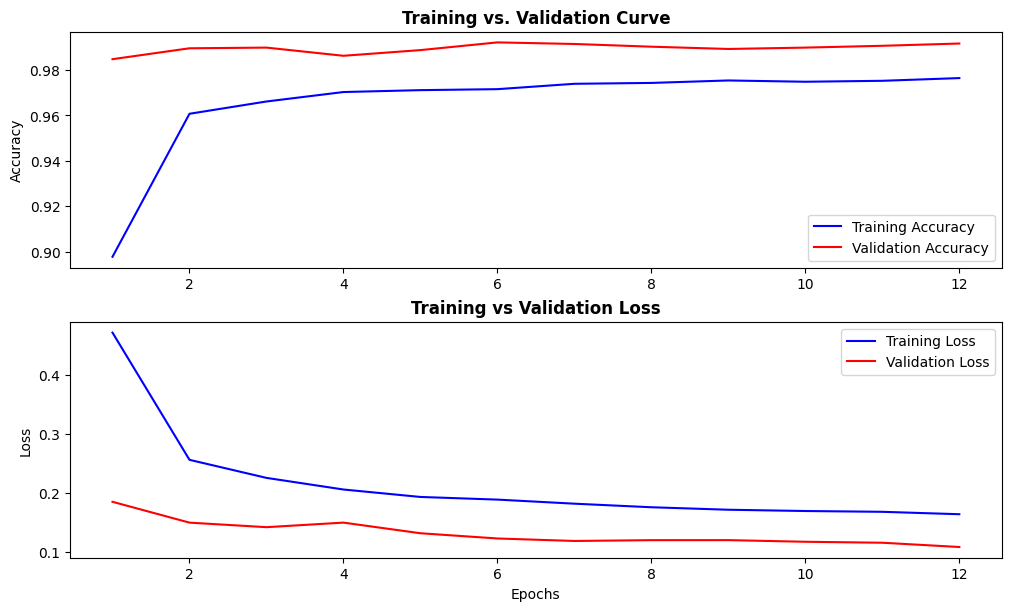

In [49]:
epoch_range = range(1, len(model_history.history['accuracy']) + 1)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), layout='constrained')
ax[0].plot(epoch_range, model_history.history['accuracy'], 'b-', label='Training Accuracy')
ax[0].plot(epoch_range, model_history.history['val_accuracy'], 'r-', label='Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Training vs. Validation Curve', fontweight='bold')
ax[0].legend(loc='best')

ax[1].plot(epoch_range, model_history.history['loss'], 'b', label='Training Loss')
ax[1].plot(epoch_range, model_history.history['val_loss'], 'r', label='Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_title('Training vs Validation Loss', fontweight='bold')
ax[1].legend(loc='best')

plt.xlabel('Epochs')
plt.show()

The overall accuracy that the model gives from the evaluate function is around 99.2% 

In [50]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 2s - 8ms/step - accuracy: 0.9917 - loss: 0.1078

Test accuracy: 0.9916999936103821


### Confusion Matrix

The confusion matrix helps visualize where the model struggles to classify the digits. 

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


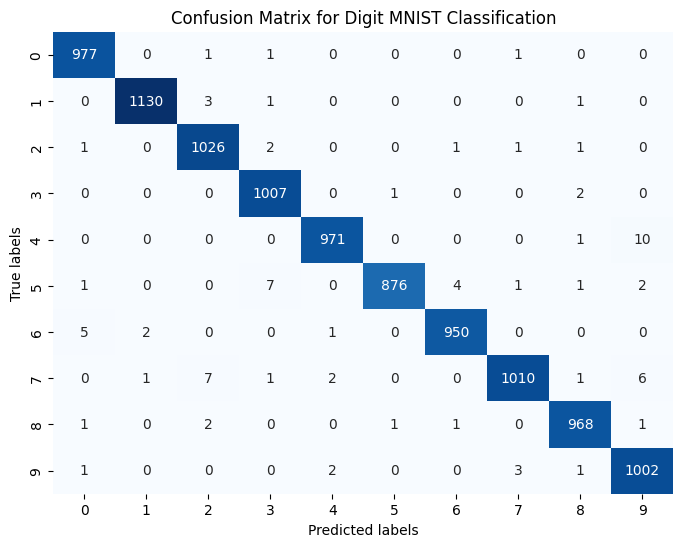

In [51]:
# Predict the test set
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Digit MNIST Classification')
plt.show()

From this chart, we can see that the model struggles with predicting 4s and 9s and 7s and 2s. The true value of 4 is oftentimes predicted to be a 9 which when considering many handwriting examples can be misidentified by humans as well. 

A possible way of improving the the model could be to alter the data augmentation techniques used in the training process. Only using the technique after an initial iteration run of the model on the standard training information and only using the augmented data on middle epochs. That way the model has true training information to begin it's prediction before having slightly altered variations of the training included in the training.

---
**Citations:**

1. LeCun, Y., Cortes, C., & Burges, C. J. (2010). MNIST handwritten digit database. ATT Labs [Online].  Available: Http://Yann. Lecun. Com/Exdb/Mnist, 2.

2. Abadi, Martín, et al. TensorFlow: Large-Scale Machine Learning on Heterogeneous Systems. 2015, tensorflow.org, https://www.tensorflow.org/.

3. Chollet, François, et al. Keras. 2015, https://github.com/keras-team/keras.

**Other Assistance:**

1. Utilized Notes on Convolutional Neural Networks on October 21, 2023 from DSC-340 Machine Learning and Neural Networks taught by Dr. Julie Butler.

2. Various Wikipedia Articles for understanding specifics activations in order to clarify verbage.